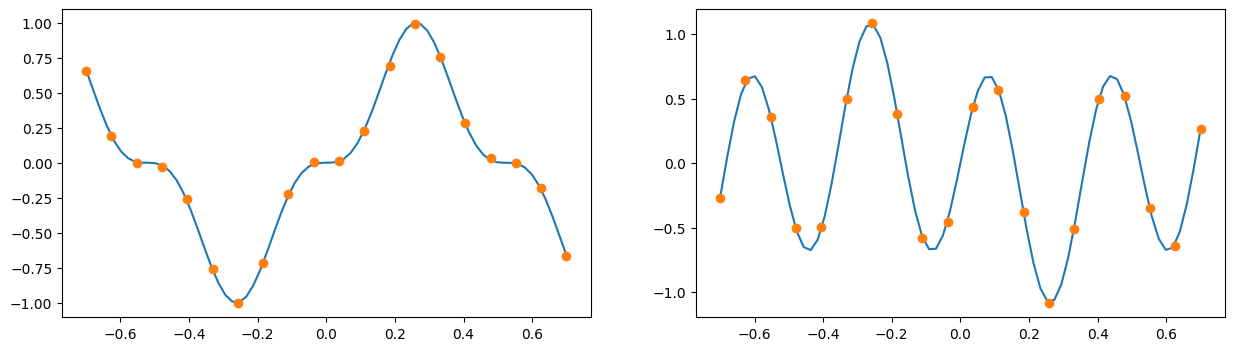

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp



x = sp.symbols('x')
u = sp.sin(6*x)**3
u_x = sp.diff(u, x)
u_xx = sp.diff(u_x, x)
u_xx = sp.lambdify(x, u_xx, 'numpy')

lam = 0.01
k = 0.7

x = np.linspace(-0.7, 0.7, 70)
u = (np.sin(6*x))**3
f = lam * u_xx(x) # + k*np.tanh(u)

n_train = 20
X_f_train = np.linspace(-0.7, 0.7, n_train)
u_f = (np.sin(6*X_f_train))**3
f_train = lam * u_xx(X_f_train) # + k*np.tanh(u_f)

X_u_train = np.linspace(-0.7, 0.7, n_train)
# X_u_train = np.array([-0.7, 0.7])
u_train = (np.sin(6*X_u_train))**3

noise = 0.01
f_train += noise*np.random.randn(n_train)
u_train += noise*np.random.randn(n_train)

fig, axs = plt.subplots(1, 2, figsize = (15,4))
axs[0].plot(x, u)
axs[0].plot(X_u_train, u_train, 'o')
axs[1].plot(x, f)
axs[1].plot(X_f_train, f_train, 'o')

x = x[:, None]; X_f_train = X_f_train[:, None]
f = f[:, None]; f_train = f_train[:, None]
X_u_train = X_u_train[:, None]
u_train = u_train[:, None]
u = u[:, None]



In [10]:
import seaborn as sns
import torch
import torch.nn as nn



import scipy.io
from utils import log_gaussian_loss, gaussian, get_kl_Gaussian_divergence
from torch.utils.tensorboard import SummaryWriter

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print('device: {}'.format(device))

from model import BBP_Model_PINN

class BBP_Model_PINN_Poisson(BBP_Model_PINN):
    def __init__(self, xt_lb, xt_ub, u_lb, u_ub, normal,
                    layers, loss_func, opt, local, res, activation,
                    learn_rate, batch_size, n_batches, 
                    prior, numerical, identification, device):




        super().__init__(xt_lb, xt_ub, u_lb, u_ub, normal,
                            layers, loss_func, opt, local, res, activation,
                            learn_rate, batch_size, n_batches, 
                            prior, numerical, identification, device)

    def initial_para(self):
       
        self.lambda1_mus = nn.Parameter(torch.Tensor(1).uniform_(0, 0.1))
        self.lambda1_rhos = nn.Parameter(torch.Tensor(1).uniform_(-3, 2))
    
        self.alpha = nn.Parameter(torch.Tensor(1).uniform_(0, 2))
    
        self.network.register_parameter('lambda1_mu', self.lambda1_mus)
        self.network.register_parameter('lambda1_rho', self.lambda1_rhos)
        self.network.register_parameter('alpha', self.alpha)
        # self.network.register_parameter('beta', self.beta)

        self.prior_lambda1 = self.prior
        self.prior_lambda2 = self.prior

    def net_U(self, xt):

        xt = 2*(xt-self.xt_lb)/(self.xt_ub-self.xt_lb) - 1
        out, KL_loss = self.network(xt)

        u = out[:, 0:1]
        log_noise_u = out[:, 1:2]
        # log_noise_f = out[:, 2:3]
        return u, log_noise_u, KL_loss

    def net_F(self, X_f, lambda1_sample):
        
        lambda_1 = lambda1_sample       
        u, _, _ = self.net_U(X_f)

        if self.normal:
            u = u*(self.u_ub-self.u_lb) + self.u_lb # reverse scaling

        u_x = torch.autograd.grad(u, X_f, torch.ones_like(u),
                                    retain_graph=True,
                                    create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, X_f, torch.ones_like(u_x),
                                    retain_graph=True,
                                    create_graph=True)[0]
    
        f_pred = lambda_1*u_xx
        return f_pred
    
    def net_F_forward(self, X_f):

        u, _, _ = self.net_U(X_f)
        if self.normal:
            u = u*(self.u_ub-self.u_lb) + self.u_lb # reverse scaling

        u_x = torch.autograd.grad(u, X_f, torch.ones_like(u),
                                    retain_graph=True,
                                    create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, X_f, torch.ones_like(u_x),
                                    retain_graph=True,
                                    create_graph=True)[0]
        f_pred = 0.01*u_xx # + 0.7*torch.tanh(u)
        return f_pred

    def fit(self, X_u, X_f, U, F, n_samples):
        self.network.train()

        # X = torch.tensor(self.X, requires_grad=True).float().to(device)
        # t = torch.tensor(self.t, requires_grad=True).float().to(device)
        if self.normal:
            U = (U-self.u_lb)/(self.u_ub-self.u_lb) # scaling
        # U = (U-self.u_mean)/self.u_std # scaling

        # reset gradient and total loss
        self.optimizer.zero_grad()

      
        fit_loss_F_total = 0
        fit_loss_U_total = 0

        for _ in range(n_samples):

            u_pred, log_noise_u, KL_loss_para = self.net_U(X_u)

            if self.identification:
                lambda1_epsilons = self.lambda1_mus.data.new(self.lambda1_mus.size()).normal_()
                lambda1_stds = torch.log(1 + torch.exp(self.lambda1_rhos))
                lambda1_sample = self.lambda1_mus + lambda1_epsilons * lambda1_stds
                
                KL_loss_lambda1 = get_kl_Gaussian_divergence(self.prior_lambda1.mu, self.prior_lambda1.sigma**2, self.lambda1_mus, lambda1_stds**2)

                f_pred = self.net_F(X_f, lambda1_sample)
          
            else:
                f_pred = self.net_F_forward(X_f)
                KL_loss_lambda1 = 0
            

            # calculate fit loss based on mean and standard deviation of output
            fit_loss_U_total += self.loss_func(u_pred, U, log_noise_u.exp(), self.network.output_dim)
            fit_loss_F_total += self.loss_func(f_pred, F, (self.alpha.exp()+1)*torch.ones_like(f_pred), self.network.output_dim)

        
        KL_loss_total = KL_loss_para + KL_loss_lambda1 
        KL_loss_total = KL_loss_total/self.n_batches # minibatches and KL reweighting
     
        self.coef = self.alpha.exp() + 1
        total_loss = KL_loss_total/U.shape[0] + fit_loss_U_total/U.shape[0] + fit_loss_F_total/F.shape[0]
        total_loss /= n_samples
        
        
        total_loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        return fit_loss_U_total/n_samples, fit_loss_F_total/n_samples, KL_loss_total, total_loss

    def predict(self, xt, n_sample):
        xt = torch.tensor(xt, requires_grad = True).float().to(self.device)

        self.network.eval()
        u_samples = []
        noises = []
        f_samples = []

        for _ in range(n_sample):
            u_pred, noise_u, _ = self.net_U(xt)
            noise_u = noise_u.exp()

            if self.identification:
                f_sample = self.net_F(xt, self.lambda1_mus)
            else:
                f_sample = self.net_F_forward(xt)
            
            if self.normal:
                u_pred = u_pred*(self.u_ub-self.u_lb) + self.u_lb # reverse scaling
                noise_u = noise_u*(self.u_ub-self.u_lb)

            f_samples.append(f_sample.detach().cpu().numpy())
            u_samples.append(u_pred.detach().cpu().numpy())
            noises.append(noise_u.detach().cpu().numpy())
        return np.array(u_samples), np.array(noises), np.array(f_samples)

device: cpu


In [11]:
x_lb = x.min(0)
x_ub = x.max(0)

u_min = u_train.min(0)
u_max = u_train.max(0)

X_u = torch.tensor(X_u_train, device = device).float()
U = torch.tensor(u_train, device = device).float()

X_f = torch.tensor(X_f_train, requires_grad = True, device = device).float()
F = torch.tensor(f_train, device = device).float()

In [12]:
# Domain bounds of x


#%% model 
local = True
identification = False
numerical = False

learn_rate = 2e-3
n_hidden = 100
opt = torch.optim.AdamW
loss_func = log_gaussian_loss
layers = [1, n_hidden, n_hidden, n_hidden, 2]

# layers = [1, n_hidden, n_hidden, n_hidden, 2] # res


prior = gaussian(0, 1)

num_epochs = 40000

n_batches = 1

batch_size = len(X_u_train)

res = True
activation = nn.Tanh()

normal = False
pinn_model = BBP_Model_PINN_Poisson(x_lb, x_ub, u_min, u_max, normal,
                                    layers, loss_func, opt, local, res, activation,
                                    learn_rate, batch_size, n_batches,
                                    prior, numerical, identification, device)

In [13]:
F

tensor([[-0.2710],
        [ 0.6418],
        [ 0.3611],
        [-0.5032],
        [-0.4931],
        [ 0.4949],
        [ 1.0840],
        [ 0.3769],
        [-0.5800],
        [-0.4571],
        [ 0.4322],
        [ 0.5692],
        [-0.3815],
        [-1.0870],
        [-0.5116],
        [ 0.5004],
        [ 0.5166],
        [-0.3445],
        [-0.6405],
        [ 0.2671]])

In [14]:
n_fit = 10
# comment = f'KdV n_sample = {N_u} n_fit = {n_fit} res = {res}'
# writer = SummaryWriter(comment = comment)

fit_loss_U_train = np.zeros(num_epochs)
fit_loss_F_train = np.zeros(num_epochs)
KL_loss_train = np.zeros(num_epochs)
loss = np.zeros(num_epochs)


for i in range(num_epochs):

    EU, EF, KL_loss, total_loss = pinn_model.fit(X_u, X_f, U, F, n_samples = n_fit)
    
    fit_loss_U_train[i] = EU.item()
    fit_loss_F_train[i] = EF.item()
    KL_loss_train[i] = KL_loss.item()
    loss[i] = total_loss.item()
    

    # writer.add_scalar("loss/total_loss", loss[i], i)
    # writer.add_scalar("loss/U_loss", fit_loss_U_train[i], i)
    # writer.add_scalar("loss/F_loss", fit_loss_F_train[i], i)
    # writer.add_scalar("loss/KL_loss", KL_loss_train[i], i)
    

    # if i % 1000 == 0:
    #     F_test = net.sample_F(X_u_test_25)
    #     fig, axs = plt.subplots(2, 2, figsize=(20, 8))
    #     axs[0,0].hist(F_test[:,0])
    #     axs[0,1].hist(F_test[:,100])
    #     axs[1,0].hist(F_test[:,150])
    #     axs[1,1].hist(F_test[:,255])
    #     plt.savefig('./plots/kdv_epoch{}_F.tiff'.format(i))


    if i % 10 == 0 or i == num_epochs - 1:

        print("Epoch: {:5d}/{:5d}, total loss = {:.3f}, Fit loss U = {:.3f}, Fit loss F = {:.3f}, KL loss = {:.3f}".format(i + 1, num_epochs, 
            loss[i], fit_loss_U_train[i], fit_loss_F_train[i], KL_loss_train[i]))

        if identification:
            lambda1_mus = pinn_model.lambda1_mus.item()
            lambda1_stds = torch.log(1 + torch.exp(pinn_model.lambda1_rhos)).item()
            print("Epoch: {:5d}/{:5d}, lambda1_mu = {:.5f}, lambda1_std = {:.3f}".format(i + 1, num_epochs,lambda1_mus, lambda1_stds))
        
    
        
        if i % 100 == 0 or i == num_epochs - 1:
            samples_star, _, f_samples = pinn_model.predict(x, 50)
            u_pred_star = samples_star.mean(axis = 0)
            f_pred_star = f_samples.mean(axis = 0)

            error_star = np.linalg.norm(u-u_pred_star, 2)/np.linalg.norm(u, 2)
            error_f = np.linalg.norm(f-f_pred_star, 2)/np.linalg.norm(f, 2)
            


            samples_train, _, _ = pinn_model.predict(X_u_train, 50)
            u_pred_train = samples_train.mean(axis=0)
            error_train = np.linalg.norm(u_train-u_pred_train, 2)/np.linalg.norm(u_train, 2)

            print("Epoch: {:5d}/{:5d}, error_test = {:.5f}, error_train = {:.5f}".format(i+1, num_epochs, error_star, error_train))
            print("Epoch: {:5d}/{:5d}, error_f = {:.5f}".format(i+1, num_epochs, error_f))
            # writer.add_scalars("loss/train_test", {'train':error_train, 'test':error_star}, i)
    
        
        
        # print("Epoch: {:5d}/{:5d}, alpha = {:.5f}, beta = {:.5f}".format(i+1, num_epochs, pinn_model.coef[0].item(), pinn_model.coef[1].item()))
        print("Epoch: {:5d}/{:5d}, alpha = {:.5f}".format(i+1, num_epochs, pinn_model.coef.item()))

        print()

# writer.close()
#%%




Epoch:     1/40000, total loss = 419.133, Fit loss U = 4.190, Fit loss F = 34.781, KL loss = 83436.844
Epoch:     1/40000, error_test = 0.99047, error_train = 1.00618
Epoch:     1/40000, error_f = 1.00004
Epoch:     1/40000, alpha = 5.66337

Epoch:    11/40000, total loss = 418.672, Fit loss U = 3.066, Fit loss F = 34.748, KL loss = 83356.227
Epoch:    11/40000, alpha = 5.65391

Epoch:    21/40000, total loss = 418.235, Fit loss U = 2.408, Fit loss F = 34.715, KL loss = 83275.719
Epoch:    21/40000, alpha = 5.64447

Epoch:    31/40000, total loss = 417.805, Fit loss U = 1.881, Fit loss F = 34.681, KL loss = 83195.320
Epoch:    31/40000, alpha = 5.63504

Epoch:    41/40000, total loss = 417.384, Fit loss U = 1.517, Fit loss F = 34.648, KL loss = 83115.062
Epoch:    41/40000, alpha = 5.62564

Epoch:    51/40000, total loss = 416.957, Fit loss U = 1.023, Fit loss F = 34.615, KL loss = 83034.938
Epoch:    51/40000, alpha = 5.61625

Epoch:    61/40000, total loss = 416.510, Fit loss U = 0.1

KeyboardInterrupt: 

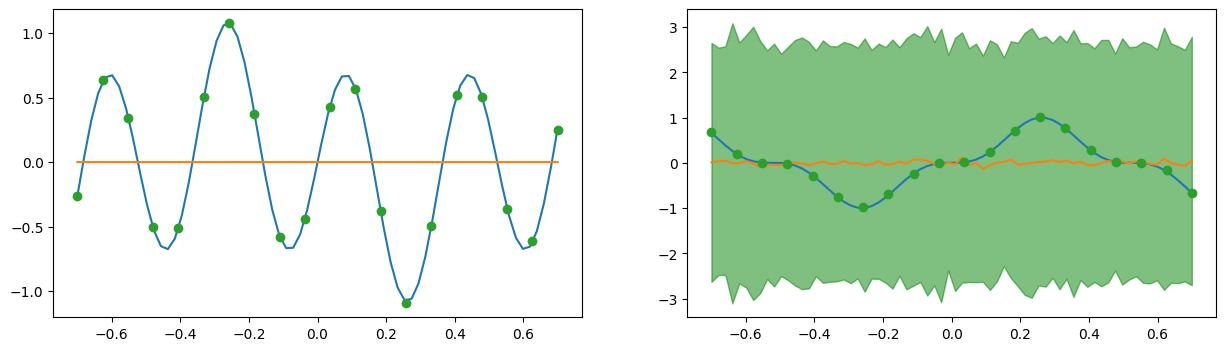

In [ ]:

def get_res(X):
    samples, noises, f_samples = pinn_model.predict(X, 100)
    u_pred = samples.mean(axis = 0)
    f_pred = f_samples.mean(axis = 0)
    aleatoric = (noises**2).mean(axis = 0)**0.5
    epistemic = samples.var(axis = 0)**0.5
    total_unc = (aleatoric**2 + epistemic**2)**0.5

    return u_pred.ravel(), f_pred.ravel(), aleatoric.ravel(), epistemic.ravel(), total_unc.ravel()

u_pred, f_pred, aleatoric, epistemic, total_unc = get_res(x)

fig, axs = plt.subplots(1, 2, figsize = (15,4))
axs[0].plot(x, f)
axs[0].plot(x, f_pred)
axs[0].plot(X_f_train, f_train, 'o')

axs[1].plot(x, u)
axs[1].plot(x, u_pred)
axs[1].plot(X_u_train, u_train, 'o')
axs[1].fill_between(x.ravel(), u_pred-2*total_unc, u_pred+2*total_unc, color = 'g', alpha = 0.5, label = 'Epistemic + Aleatoric')




In [ ]:
for name, para in pinn_model.network.named_parameters():
    print(name, para)

lambda1_mu Parameter containing:
tensor([0.0302], requires_grad=True)
lambda1_rho Parameter containing:
tensor([1.3662], requires_grad=True)
alpha Parameter containing:
tensor([-13.4181], requires_grad=True)
last_layer.W_mu Parameter containing:
tensor([[ 1.6277e-03, -1.7501e-03],
        [-7.9999e-04, -3.4783e-03],
        [-6.0921e-04, -2.1888e-03],
        [ 4.4109e-04,  1.3757e-03],
        [-1.5744e-03, -1.8203e-03],
        [ 8.6123e-06,  1.4729e-03],
        [ 8.6955e-04,  3.6897e-03],
        [ 1.5298e-03,  9.3304e-04],
        [-6.6330e-04,  7.7340e-06],
        [ 4.1315e-04,  8.4451e-04],
        [ 4.5148e-03, -1.5925e-03],
        [-3.5029e-03, -2.7679e-04],
        [ 5.1169e-04, -1.8087e-03],
        [-2.1285e-03, -5.8471e-04],
        [ 1.6366e-04,  1.7354e-03],
        [-2.7697e-03,  2.7012e-03],
        [ 1.0186e-03, -1.3753e-03],
        [-1.1058e-03, -5.0656e-04],
        [ 5.5778e-04,  2.8129e-03],
        [-3.3109e-04,  1.7627e-03],
        [-2.0930e-04, -2.9715e-04]